In [34]:
from faker import Faker
from tensorflow.keras.layers import RepeatVector, Concatenate, Dense, Dot, Activation
from tensorflow.keras.layers import Input, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import numpy as np
import random
from babel.dates import format_date
import os 

os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [36]:
faker = Faker()
np.random.seed(5)
BATCH_SIZE=128
MODEL_OUTPUT_PATH="./output/date-formatter.hdf5"

In [19]:
FORMATS = ['short',
           'medium',
           'medium',
           'medium',
           'long','long',
           'long','long',
           'long','full',
           'full','full',
           'd MMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'd MMMM YYY',
           'dd/MM/YYY',
           'EE d, MMM YYY',
           'EEEE d, MMMM YYY',
           'MMM d, YYY',
           'MMMM d, YYY',
           'YYY, d MMM',
           'YYY, d MMMM',
           'EE YYY, d MMMM',
           'EEEE YYY, d MM'
          ]
for format in FORMATS:
    print('%s => %s' %(format, format_date(faker.date_object(), format=format, locale='en')))

short => 4/4/79
medium => Oct 31, 1984
medium => Dec 22, 1979
medium => Jan 10, 2015
long => October 4, 2019
long => August 11, 2005
long => April 26, 1973
long => January 26, 1999
long => September 25, 2004
full => Friday, June 9, 2000
full => Saturday, March 12, 2005
full => Sunday, July 24, 1977
d MMM YYY => 11 Sep 2001
d MMMM YYY => 3 March 1971
d MMMM YYY => 17 July 1988
d MMMM YYY => 18 April 2003
d MMMM YYY => 24 January 1979
d MMMM YYY => 13 November 2001
dd/MM/YYY => 01/01/1981
EE d, MMM YYY => Tue 6, Feb 1973
EEEE d, MMMM YYY => Friday 1, December 1972
MMM d, YYY => Feb 15, 1992
MMMM d, YYY => December 16, 2020
YYY, d MMM => 2017, 26 Oct
YYY, d MMMM => 1977, 8 September
EE YYY, d MMMM => Tue 2009, 6 October
EEEE YYY, d MM => Sunday 2004, 21 03


In [20]:
def random_date():
    dt = faker.date_time_between(start_date = '-500y',end_date='+50y')
    try:
        date = format_date(dt, format=random.choice(FORMATS), locale='en')
        human_readable = date.lower().replace(',', '')
        machine_readable =  format_date(dt, format="YYYY-MM-dd", locale='en')
    except AttributeError as e:
        return None, None, None
    return human_readable, machine_readable

In [21]:
random_date()

('thursday 1877 19 04', '1877-04-19')

In [22]:
human_vocab = set()
machine_vocab = set()
dataset = []
m = int(BATCH_SIZE*100*4)

for i in range(m):
  hd,md = random_date()
  dataset.append((hd,md))
  human_vocab.update( tuple(hd) )
  machine_vocab.update( tuple(md) )
    
# self-made tokenization
  
human_vocab.update(('<pad>','<unk>'))
human_vocab = dict(enumerate(human_vocab))
# human_vocab = tokenizer.word_index
human_vocab = { v:i for i,v in human_vocab.items()  }
human_vocab_index_word = dict(enumerate(human_vocab))

machine_vocab.add('<unk>')
machine_vocab = dict(enumerate(machine_vocab))
# word_index
inv_machine_vocab = { v:i for i,v in machine_vocab.items()}

print(len(dataset),len(human_vocab),len(machine_vocab))
dataset[:10]

51200 36 12


[('friday 7 november 1862', '1862-11-07'),
 ('fri 8 oct 1909', '1909-10-08'),
 ('december 10 1618', '1618-12-10'),
 ('friday july 25 1947', '1947-07-25'),
 ('november 19 1797', '1797-11-19'),
 ('mar 2 1884', '1884-03-02'),
 ('1786 7 sep', '1786-09-07'),
 ('25/09/1912', '1912-09-25'),
 ('dec 23 2064', '2064-12-23'),
 ('1594 4 march', '1594-03-04')]

In [23]:
#test set
t = BATCH_SIZE*10*4
testset= []
for i in range(t):
  hd,md = random_date()
  testset.append((hd,md))

In [24]:
HUMAN_VOCAB = len(human_vocab)
MACHINE_VOCAB = len(machine_vocab)
batch_size=128
Tx = 30
Ty = 10
print( HUMAN_VOCAB, MACHINE_VOCAB )

36 12


In [25]:
def string_to_ohe(string, T, vocab):
    # in a seq-to-seq model batch of one-hot vectors is the expected output of the final softmax layer
    # vocab play the role as tokenizer.word_index, i.e., word to index
    # in the past I work on tokenizing words, this time we tokenizer every single characters
    string = string.lower()
    arr = []
    while len(arr) < len(string):
        curr_index = len(arr)
        arr.append(vocab.get(string[curr_index], vocab['<unk>']))

    while len(arr) < T:
        arr.append(vocab['<pad>'])
    
    onehot = np.zeros((T,len(vocab)))
    for i in range(T):
        onehot[i, arr[i]] = 1
        
    return onehot, arr

def output_to_date(out, vocab):
    # this time the "vocab" is index_word
    arr = np.argmax(out,axis=-1)
    string = ''
    for i in arr:
        string += vocab[i]
        
    return string

In [26]:
X = []
Y = []

for x,y in dataset:
    X.append(string_to_ohe(x, Tx, human_vocab)[0])
    Y.append(string_to_ohe(y, Ty, inv_machine_vocab)[0])
    
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((51200, 30, 36), (51200, 10, 12))

In [27]:
output_to_date(X[random.randint(0,50000)], human_vocab_index_word)

'7 mar 1875<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [28]:
Xt = []
Yt = []

for x,y in testset:
    Xt.append(string_to_ohe(x, Tx, human_vocab)[0])
    Yt.append(string_to_ohe(y, Ty, inv_machine_vocab)[0])
    
Xt,Yt = np.array(Xt), np.array(Yt)
Xt.shape, Yt.shape

((5120, 30, 36), (5120, 10, 12))

In [29]:
#combines activations generated from BiLSTM with previous state of Post LSTM cell to get attention to be given to each timestep
#heart of attention model

def one_step_attention(a, s_prev):
    x = RepeatVector(Tx)(s_prev)             
    # this is to make use of all the information from output hidden state from the first LSTM layer
    # and "current" hidden state of second LSTM layer\
    # shape of a: (none, T_x, 2*H_encoder), shape off current x: (none, T_x, H_decoder)
    x = Concatenate(axis=-1)([a, x])        
    # shape of x: (none, T_x, 2*H_encoder + H_decoder)
    e = Dense(Ty, activation='tanh')(x)    
    energy = Dense(1, activation='relu')(e) 
    # shape of energy: (none, T_x, 1)
    alphas = Activation('softmax')(energy)
    # shape of alphas: (none, T_x)
    # alphas are the attention weight
    # therefore context is the weighted sum of our first LSTM layer's hidden state
    # context can be thought of as fine-tuned output hidden state that is to be fed into decoder LSTM model
    context = Dot(axes=1)([alphas,a])
    
    return context

<img width="50%" src="./attention_mechanism_2.png"><img width="90%" src="./attention_mechanism_1.png">

In [30]:
n_a = 32 #pre attention LSTM state, since Bi directional attention=64
n_s = 64 #post attention LSTM state

inp = Input((Tx, HUMAN_VOCAB))
s0 = Input((n_s,))
c0 = Input((n_s,))

outputs = []

s = s0
c = c0
a = Bidirectional(
    LSTM(
        n_a, 
        batch_input_shape=(batch_size, Tx, HUMAN_VOCAB),
        return_sequences=True
    ))(inp) #generate hidden state for every timestep

postLSTM = LSTM(n_s, return_state = True)

output = Dense(MACHINE_VOCAB, activation='softmax') #our final output layer

for _ in range(Ty): #iterate for every output step
    context = one_step_attention(a, s) #get context
    s, _, c = postLSTM(context, initial_state=[s, c]) #generate cell_state_seq(currently 1), cell_state, memory  
    out = output(s)
    outputs.append(out)
  
model = Model([inp, s0, c0], outputs)

In [31]:
model.compile( 
    optimizer=Adam(lr=0.005, decay=0.01),
    loss='categorical_crossentropy',
    metrics=['acc'] 
)

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

Y = list(Y.swapaxes(0,1))
Yt = list(Yt.swapaxes(0,1))

history = model.fit([X, s0, c0], Y, epochs=100, 
                    validation_data=([Xt,np.zeros((t, n_s)),np.zeros((t, n_s))],Yt), 
                    batch_size=BATCH_SIZE, verbose=1)

model.save_weights('attention_weights.h5')

Epoch 1/100
400/400 [==============================] - 37s 51ms/step - loss: 15.7731 - dense_loss: 0.6692 - dense_1_loss: 1.6972 - dense_2_loss: 1.9641 - dense_3_loss: 2.0815 - dense_4_loss: 0.9155 - dense_5_loss: 1.2792 - dense_6_loss: 2.1925 - dense_7_loss: 1.0459 - dense_8_loss: 1.6271 - dense_9_loss: 2.3009 - dense_acc: 0.8630 - dense_1_acc: 0.3712 - dense_2_acc: 0.2845 - dense_3_acc: 0.2458 - dense_4_acc: 0.8092 - dense_5_acc: 0.4226 - dense_6_acc: 0.2048 - dense_7_acc: 0.7065 - dense_8_acc: 0.3104 - dense_9_acc: 0.1720 - val_loss: 6.8830 - val_dense_loss: 0.1514 - val_dense_1_loss: 0.9220 - val_dense_2_loss: 1.3535 - val_dense_3_loss: 1.3714 - val_dense_4_loss: 0.0163 - val_dense_5_loss: 0.1255 - val_dense_6_loss: 0.7013 - val_dense_7_loss: 0.0206 - val_dense_8_loss: 0.6963 - val_dense_9_loss: 1.5247 - val_dense_acc: 0.9508 - val_dense_1_acc: 0.6049 - val_dense_2_acc: 0.4369 - val_dense_3_acc: 0.4316 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9771 - val_dense_6_acc: 0.8334 - 

Epoch 9/100
400/400 [==============================] - 16s 41ms/step - loss: 2.7594 - dense_loss: 0.0462 - dense_1_loss: 0.4316 - dense_2_loss: 0.8235 - dense_3_loss: 0.5620 - dense_4_loss: 0.0025 - dense_5_loss: 0.0405 - dense_6_loss: 0.2127 - dense_7_loss: 0.0036 - dense_8_loss: 0.2119 - dense_9_loss: 0.4248 - dense_acc: 0.9888 - dense_1_acc: 0.8524 - dense_2_acc: 0.6304 - dense_3_acc: 0.8187 - dense_4_acc: 1.0000 - dense_5_acc: 0.9863 - dense_6_acc: 0.9436 - dense_7_acc: 0.9999 - dense_8_acc: 0.9300 - dense_9_acc: 0.8544 - val_loss: 2.6358 - val_dense_loss: 0.0382 - val_dense_1_loss: 0.4125 - val_dense_2_loss: 0.7867 - val_dense_3_loss: 0.5302 - val_dense_4_loss: 0.0025 - val_dense_5_loss: 0.0400 - val_dense_6_loss: 0.2035 - val_dense_7_loss: 0.0029 - val_dense_8_loss: 0.2083 - val_dense_9_loss: 0.4110 - val_dense_acc: 0.9920 - val_dense_1_acc: 0.8592 - val_dense_2_acc: 0.6621 - val_dense_3_acc: 0.8285 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9859 - val_dense_6_acc: 0.9447 - v

Epoch 17/100
400/400 [==============================] - 16s 40ms/step - loss: 1.6993 - dense_loss: 0.0292 - dense_1_loss: 0.2774 - dense_2_loss: 0.4724 - dense_3_loss: 0.3403 - dense_4_loss: 0.0014 - dense_5_loss: 0.0326 - dense_6_loss: 0.1536 - dense_7_loss: 0.0016 - dense_8_loss: 0.1413 - dense_9_loss: 0.2495 - dense_acc: 0.9935 - dense_1_acc: 0.9127 - dense_2_acc: 0.8399 - dense_3_acc: 0.8996 - dense_4_acc: 1.0000 - dense_5_acc: 0.9882 - dense_6_acc: 0.9580 - dense_7_acc: 0.9999 - dense_8_acc: 0.9553 - dense_9_acc: 0.9199 - val_loss: 1.6919 - val_dense_loss: 0.0247 - val_dense_1_loss: 0.2779 - val_dense_2_loss: 0.4703 - val_dense_3_loss: 0.3358 - val_dense_4_loss: 0.0012 - val_dense_5_loss: 0.0322 - val_dense_6_loss: 0.1586 - val_dense_7_loss: 0.0014 - val_dense_8_loss: 0.1421 - val_dense_9_loss: 0.2478 - val_dense_acc: 0.9947 - val_dense_1_acc: 0.9143 - val_dense_2_acc: 0.8365 - val_dense_3_acc: 0.8945 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9887 - val_dense_6_acc: 0.9529 - 

Epoch 25/100
400/400 [==============================] - 16s 40ms/step - loss: 1.2954 - dense_loss: 0.0249 - dense_1_loss: 0.2196 - dense_2_loss: 0.3453 - dense_3_loss: 0.2619 - dense_4_loss: 7.7910e-04 - dense_5_loss: 0.0292 - dense_6_loss: 0.1314 - dense_7_loss: 9.3120e-04 - dense_8_loss: 0.1037 - dense_9_loss: 0.1777 - dense_acc: 0.9941 - dense_1_acc: 0.9371 - dense_2_acc: 0.8916 - dense_3_acc: 0.9216 - dense_4_acc: 1.0000 - dense_5_acc: 0.9895 - dense_6_acc: 0.9620 - dense_7_acc: 1.0000 - dense_8_acc: 0.9681 - dense_9_acc: 0.9464 - val_loss: 1.3143 - val_dense_loss: 0.0199 - val_dense_1_loss: 0.2160 - val_dense_2_loss: 0.3531 - val_dense_3_loss: 0.2671 - val_dense_4_loss: 6.0930e-04 - val_dense_5_loss: 0.0296 - val_dense_6_loss: 0.1380 - val_dense_7_loss: 7.4367e-04 - val_dense_8_loss: 0.1054 - val_dense_9_loss: 0.1840 - val_dense_acc: 0.9957 - val_dense_1_acc: 0.9377 - val_dense_2_acc: 0.8904 - val_dense_3_acc: 0.9162 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9902 - val_dense_

Epoch 33/100
400/400 [==============================] - 17s 41ms/step - loss: 1.0601 - dense_loss: 0.0206 - dense_1_loss: 0.1791 - dense_2_loss: 0.2731 - dense_3_loss: 0.2116 - dense_4_loss: 5.7392e-04 - dense_5_loss: 0.0264 - dense_6_loss: 0.1208 - dense_7_loss: 7.0626e-04 - dense_8_loss: 0.0840 - dense_9_loss: 0.1432 - dense_acc: 0.9948 - dense_1_acc: 0.9497 - dense_2_acc: 0.9205 - dense_3_acc: 0.9360 - dense_4_acc: 1.0000 - dense_5_acc: 0.9902 - dense_6_acc: 0.9633 - dense_7_acc: 1.0000 - dense_8_acc: 0.9751 - dense_9_acc: 0.9577 - val_loss: 1.0988 - val_dense_loss: 0.0177 - val_dense_1_loss: 0.1799 - val_dense_2_loss: 0.2836 - val_dense_3_loss: 0.2245 - val_dense_4_loss: 4.2878e-04 - val_dense_5_loss: 0.0288 - val_dense_6_loss: 0.1252 - val_dense_7_loss: 5.5997e-04 - val_dense_8_loss: 0.0869 - val_dense_9_loss: 0.1511 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9498 - val_dense_2_acc: 0.9141 - val_dense_3_acc: 0.9324 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9893 - val_dense_

Epoch 41/100
400/400 [==============================] - 16s 39ms/step - loss: 0.9313 - dense_loss: 0.0202 - dense_1_loss: 0.1608 - dense_2_loss: 0.2297 - dense_3_loss: 0.1865 - dense_4_loss: 4.0321e-04 - dense_5_loss: 0.0239 - dense_6_loss: 0.1116 - dense_7_loss: 5.0739e-04 - dense_8_loss: 0.0720 - dense_9_loss: 0.1257 - dense_acc: 0.9944 - dense_1_acc: 0.9551 - dense_2_acc: 0.9332 - dense_3_acc: 0.9445 - dense_4_acc: 1.0000 - dense_5_acc: 0.9913 - dense_6_acc: 0.9664 - dense_7_acc: 1.0000 - dense_8_acc: 0.9796 - dense_9_acc: 0.9624 - val_loss: 0.9628 - val_dense_loss: 0.0166 - val_dense_1_loss: 0.1588 - val_dense_2_loss: 0.2410 - val_dense_3_loss: 0.1954 - val_dense_4_loss: 3.1679e-04 - val_dense_5_loss: 0.0262 - val_dense_6_loss: 0.1180 - val_dense_7_loss: 3.6526e-04 - val_dense_8_loss: 0.0744 - val_dense_9_loss: 0.1317 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9564 - val_dense_2_acc: 0.9287 - val_dense_3_acc: 0.9406 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9906 - val_dense_

Epoch 49/100
400/400 [==============================] - 16s 39ms/step - loss: 0.8289 - dense_loss: 0.0202 - dense_1_loss: 0.1411 - dense_2_loss: 0.1975 - dense_3_loss: 0.1628 - dense_4_loss: 3.1124e-04 - dense_5_loss: 0.0251 - dense_6_loss: 0.1052 - dense_7_loss: 4.2663e-04 - dense_8_loss: 0.0628 - dense_9_loss: 0.1134 - dense_acc: 0.9945 - dense_1_acc: 0.9613 - dense_2_acc: 0.9457 - dense_3_acc: 0.9521 - dense_4_acc: 1.0000 - dense_5_acc: 0.9906 - dense_6_acc: 0.9674 - dense_7_acc: 1.0000 - dense_8_acc: 0.9836 - dense_9_acc: 0.9659 - val_loss: 0.8687 - val_dense_loss: 0.0159 - val_dense_1_loss: 0.1448 - val_dense_2_loss: 0.2102 - val_dense_3_loss: 0.1743 - val_dense_4_loss: 2.9527e-04 - val_dense_5_loss: 0.0258 - val_dense_6_loss: 0.1128 - val_dense_7_loss: 3.4093e-04 - val_dense_8_loss: 0.0661 - val_dense_9_loss: 0.1181 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9604 - val_dense_2_acc: 0.9412 - val_dense_3_acc: 0.9473 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9902 - val_dense_

Epoch 57/100
400/400 [==============================] - 16s 39ms/step - loss: 0.7619 - dense_loss: 0.0197 - dense_1_loss: 0.1333 - dense_2_loss: 0.1771 - dense_3_loss: 0.1471 - dense_4_loss: 2.7298e-04 - dense_5_loss: 0.0223 - dense_6_loss: 0.0990 - dense_7_loss: 3.9340e-04 - dense_8_loss: 0.0575 - dense_9_loss: 0.1053 - dense_acc: 0.9944 - dense_1_acc: 0.9611 - dense_2_acc: 0.9515 - dense_3_acc: 0.9583 - dense_4_acc: 1.0000 - dense_5_acc: 0.9918 - dense_6_acc: 0.9701 - dense_7_acc: 1.0000 - dense_8_acc: 0.9841 - dense_9_acc: 0.9688 - val_loss: 0.8001 - val_dense_loss: 0.0154 - val_dense_1_loss: 0.1346 - val_dense_2_loss: 0.1871 - val_dense_3_loss: 0.1599 - val_dense_4_loss: 3.5452e-04 - val_dense_5_loss: 0.0250 - val_dense_6_loss: 0.1061 - val_dense_7_loss: 4.4009e-04 - val_dense_8_loss: 0.0614 - val_dense_9_loss: 0.1099 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9619 - val_dense_2_acc: 0.9492 - val_dense_3_acc: 0.9525 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9914 - val_dense_

Epoch 65/100
400/400 [==============================] - 15s 38ms/step - loss: 0.7173 - dense_loss: 0.0194 - dense_1_loss: 0.1260 - dense_2_loss: 0.1596 - dense_3_loss: 0.1397 - dense_4_loss: 2.4055e-04 - dense_5_loss: 0.0237 - dense_6_loss: 0.0953 - dense_7_loss: 3.7558e-04 - dense_8_loss: 0.0538 - dense_9_loss: 0.0992 - dense_acc: 0.9948 - dense_1_acc: 0.9635 - dense_2_acc: 0.9572 - dense_3_acc: 0.9629 - dense_4_acc: 1.0000 - dense_5_acc: 0.9910 - dense_6_acc: 0.9702 - dense_7_acc: 1.0000 - dense_8_acc: 0.9855 - dense_9_acc: 0.9699 - val_loss: 0.7450 - val_dense_loss: 0.0149 - val_dense_1_loss: 0.1269 - val_dense_2_loss: 0.1693 - val_dense_3_loss: 0.1477 - val_dense_4_loss: 3.0979e-04 - val_dense_5_loss: 0.0239 - val_dense_6_loss: 0.1037 - val_dense_7_loss: 3.0719e-04 - val_dense_8_loss: 0.0567 - val_dense_9_loss: 0.1013 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9639 - val_dense_2_acc: 0.9559 - val_dense_3_acc: 0.9568 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9910 - val_dense_

Epoch 73/100
400/400 [==============================] - 15s 38ms/step - loss: 0.6577 - dense_loss: 0.0190 - dense_1_loss: 0.1202 - dense_2_loss: 0.1465 - dense_3_loss: 0.1221 - dense_4_loss: 2.2381e-04 - dense_5_loss: 0.0208 - dense_6_loss: 0.0888 - dense_7_loss: 3.4542e-04 - dense_8_loss: 0.0498 - dense_9_loss: 0.0901 - dense_acc: 0.9945 - dense_1_acc: 0.9645 - dense_2_acc: 0.9631 - dense_3_acc: 0.9681 - dense_4_acc: 1.0000 - dense_5_acc: 0.9919 - dense_6_acc: 0.9719 - dense_7_acc: 1.0000 - dense_8_acc: 0.9866 - dense_9_acc: 0.9732 - val_loss: 0.7002 - val_dense_loss: 0.0147 - val_dense_1_loss: 0.1215 - val_dense_2_loss: 0.1547 - val_dense_3_loss: 0.1361 - val_dense_4_loss: 2.2942e-04 - val_dense_5_loss: 0.0232 - val_dense_6_loss: 0.0996 - val_dense_7_loss: 2.6318e-04 - val_dense_8_loss: 0.0533 - val_dense_9_loss: 0.0965 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9652 - val_dense_2_acc: 0.9613 - val_dense_3_acc: 0.9617 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9916 - val_dense_

Epoch 81/100
400/400 [==============================] - 15s 38ms/step - loss: 0.6204 - dense_loss: 0.0169 - dense_1_loss: 0.1139 - dense_2_loss: 0.1340 - dense_3_loss: 0.1128 - dense_4_loss: 1.9769e-04 - dense_5_loss: 0.0201 - dense_6_loss: 0.0881 - dense_7_loss: 2.7094e-04 - dense_8_loss: 0.0454 - dense_9_loss: 0.0887 - dense_acc: 0.9953 - dense_1_acc: 0.9660 - dense_2_acc: 0.9680 - dense_3_acc: 0.9707 - dense_4_acc: 1.0000 - dense_5_acc: 0.9923 - dense_6_acc: 0.9718 - dense_7_acc: 1.0000 - dense_8_acc: 0.9877 - dense_9_acc: 0.9721 - val_loss: 0.6642 - val_dense_loss: 0.0145 - val_dense_1_loss: 0.1168 - val_dense_2_loss: 0.1425 - val_dense_3_loss: 0.1277 - val_dense_4_loss: 2.3134e-04 - val_dense_5_loss: 0.0224 - val_dense_6_loss: 0.0972 - val_dense_7_loss: 2.4598e-04 - val_dense_8_loss: 0.0507 - val_dense_9_loss: 0.0918 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9662 - val_dense_2_acc: 0.9670 - val_dense_3_acc: 0.9654 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9918 - val_dense_

Epoch 89/100
400/400 [==============================] - 15s 38ms/step - loss: 0.5957 - dense_loss: 0.0185 - dense_1_loss: 0.1125 - dense_2_loss: 0.1221 - dense_3_loss: 0.1070 - dense_4_loss: 1.7067e-04 - dense_5_loss: 0.0202 - dense_6_loss: 0.0843 - dense_7_loss: 2.6127e-04 - dense_8_loss: 0.0454 - dense_9_loss: 0.0852 - dense_acc: 0.9946 - dense_1_acc: 0.9658 - dense_2_acc: 0.9728 - dense_3_acc: 0.9735 - dense_4_acc: 1.0000 - dense_5_acc: 0.9922 - dense_6_acc: 0.9731 - dense_7_acc: 1.0000 - dense_8_acc: 0.9882 - dense_9_acc: 0.9733 - val_loss: 0.6332 - val_dense_loss: 0.0142 - val_dense_1_loss: 0.1124 - val_dense_2_loss: 0.1330 - val_dense_3_loss: 0.1201 - val_dense_4_loss: 1.7807e-04 - val_dense_5_loss: 0.0220 - val_dense_6_loss: 0.0953 - val_dense_7_loss: 2.1484e-04 - val_dense_8_loss: 0.0479 - val_dense_9_loss: 0.0879 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9666 - val_dense_2_acc: 0.9701 - val_dense_3_acc: 0.9695 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9920 - val_dense_

Epoch 97/100
400/400 [==============================] - 15s 38ms/step - loss: 0.5612 - dense_loss: 0.0186 - dense_1_loss: 0.1060 - dense_2_loss: 0.1144 - dense_3_loss: 0.1002 - dense_4_loss: 1.7818e-04 - dense_5_loss: 0.0195 - dense_6_loss: 0.0817 - dense_7_loss: 2.6893e-04 - dense_8_loss: 0.0410 - dense_9_loss: 0.0794 - dense_acc: 0.9945 - dense_1_acc: 0.9676 - dense_2_acc: 0.9763 - dense_3_acc: 0.9779 - dense_4_acc: 1.0000 - dense_5_acc: 0.9926 - dense_6_acc: 0.9737 - dense_7_acc: 1.0000 - dense_8_acc: 0.9890 - dense_9_acc: 0.9757 - val_loss: 0.6069 - val_dense_loss: 0.0141 - val_dense_1_loss: 0.1098 - val_dense_2_loss: 0.1245 - val_dense_3_loss: 0.1135 - val_dense_4_loss: 1.6136e-04 - val_dense_5_loss: 0.0214 - val_dense_6_loss: 0.0918 - val_dense_7_loss: 2.2032e-04 - val_dense_8_loss: 0.0458 - val_dense_9_loss: 0.0856 - val_dense_acc: 0.9961 - val_dense_1_acc: 0.9674 - val_dense_2_acc: 0.9723 - val_dense_3_acc: 0.9707 - val_dense_4_acc: 1.0000 - val_dense_5_acc: 0.9918 - val_dense_

In [35]:
model.save(MODEL_OUTPUT_PATH)

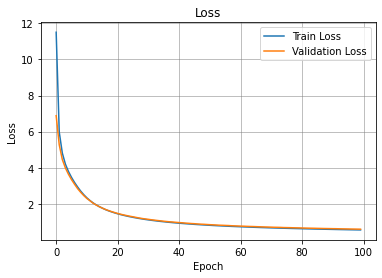

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
epoch_list = history.epoch
plt.plot(epoch_list, history.history['loss'], label='Train Loss')
plt.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss');plt.xlabel('Epoch');plt.title('Loss')
plt.legend(loc="best");plt.grid(color='gray', linestyle='-', linewidth=0.5)

In [53]:
model = load_model(MODEL_OUTPUT_PATH)
print(model.layers[0].input_shape)
s0 = np.zeros((n_s,))
c0 = np.zeros((n_s,))
def getTranslation(date,model):
    date = date.lower().replace(',','')
    source = np.array(string_to_ohe(date, Tx, human_vocab)[0])
    prediction = np.array(model.predict([source,s0[],c0]))
    prediction = np.squeeze(prediction.swapaxes(0,1))
    return output_to_date(prediction,machine_vocab)

EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', 
            '1 March 2001','jun 10 2017','11/07/2002']

for example in EXAMPLES:
    print(f"{example} -> {getTranslation(example,model)}")

[(None, 30, 36)]


ValueError: Data cardinality is ambiguous:
  x sizes: 30, 64, 64
Make sure all arrays contain the same number of samples.